# Text classification with Neural Networks
In this jupyter notebook, we will learn several strategies to train a deep learning neural network for text classification task, including:
- A binary classification task with movie reviews dataset
  - a densly connected NN with multi-hot encoding
  - a bidirectional LSTM with self-trained embedding
  - a bidirectional LSTM with pre-trained embedding
- A multi-class classification task with newswires dataset

## A binary text classification example with movie reviews

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# import os
# os.listdir('/content/drive/MyDrive/DLP/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read data from Google drive (change to your own path)
df = pd.read_csv('/content/drive/MyDrive/DLP/IMDB Dataset.csv')
df.shape

(50000, 2)

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
Counter(df.sentiment)

Counter({'positive': 25000, 'negative': 25000})

In [ ]:
# map sentiment to integer label
df['label'] = df['sentiment'].map({'positive':1, 'negative':0})
df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


### Train a densly connected NN with multi-hot encoding
**Text vectorization with multi-hot encoding**

In [ ]:
max_length = 600
max_tokens = 20000
vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot", # try "int", "count", "multi_hot", "tf_idf"
    # output_sequence_length=max_length,
)
vectorizer.adapt(df['review'])
vectorized_text = vectorizer(df['review'])

In [ ]:
# an example of the vectorized text
vectorized_text[0]

<tf.Tensor: shape=(20000,), dtype=float32, numpy=array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)>

In [ ]:
vocab = vectorizer.get_vocabulary()
type(vocab), len(vocab)

(list, 20000)

In [ ]:
# vocab[:3]

['', '[UNK]', 'the']

In [ ]:
def decode_text(multi_hot_vec, vectorizer):
  """
  Decode indices back to text
  Note that: there's no order information in the decoded text
  """
  indices = np.where(multi_hot_vec == 1)[0]
  vocab = vectorizer.get_vocabulary()
  words = [vocab[index] for index in indices]
  return ' '.join(words)
  # vocab = vectorizer.get_vocabulary()
  # return ' '.join(vocab[i] for i in indices)

In [ ]:
# decode_text(vectorized_text[0], vectorizer)

'[UNK] the and a of to is in it i this that br was as with for but on not you are have be one its all an they from so or just about if has out what more no would which their can me well get other into first after being never where show ever your say scenes go watching thing doesnt pretty around got fact may saw right far away shows goes main watched set high death given use home classic sex episode couldnt face become youll called 1 kill side city wouldnt lack experience violence happened exactly order turned due word middle class forget street mess state mentioned audiences prison touch taste pictures appeal mainly charm developed drugs ready nasty trust reviewers skills levels graphic mebr surreal irish mainstream pulls section security focuses sold glass dare hooked struck uncomfortable oz hardcore em comfortable darker painted experimental guards agenda christians awaybr brutality regards hearted punches maximum inmates crooked cells dodgy italians injustice faint muslims shady sta

**Split the data into train/test/validation**

In [ ]:
X_train = vectorized_text[:30000]
X_test = vectorized_text[30000:40000]
X_val = vectorized_text[40000:50000]

y_train = df.label.values[:30000]
y_test = df.label.values[30000:40000]
y_val = df.label.values[40000:50000]

X_train.shape, X_test.shape, X_val.shape

(TensorShape([30000, 20000]),
 TensorShape([10000, 20000]),
 TensorShape([10000, 20000]))

**Build, compile, and train a densly connected NN**

In [ ]:
# create the model
ds_model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [ ]:
# compile the model
ds_model.compile(optimizer="rmsprop",
                 loss="binary_crossentropy",
                 metrics=["accuracy"])

In [ ]:
# # set aside a validation set
# x_val = x_train[:10000]
# partial_x_train = x_train[10000:]
# y_val = y_train[:10000]
# partial_y_train = y_train[10000:]

In [ ]:
# train the model
ds_history = ds_model.fit(X_train, y_train, epochs=20, batch_size=512,
                          validation_data=(X_val, y_val))

Epoch 1/20
59/59 [==============================] - 4s 36ms/step - loss: 0.4420 - accuracy: 0.8323 - val_loss: 0.3169 - val_accuracy: 0.8891
Epoch 2/20
59/59 [==============================] - 1s 23ms/step - loss: 0.2512 - accuracy: 0.9112 - val_loss: 0.2627 - val_accuracy: 0.8970
Epoch 3/20
59/59 [==============================] - 1s 23ms/step - loss: 0.1930 - accuracy: 0.9311 - val_loss: 0.2590 - val_accuracy: 0.8945
Epoch 4/20
59/59 [==============================] - 1s 24ms/step - loss: 0.1561 - accuracy: 0.9462 - val_loss: 0.2733 - val_accuracy: 0.8936
Epoch 5/20
59/59 [==============================] - 1s 24ms/step - loss: 0.1333 - accuracy: 0.9542 - val_loss: 0.2728 - val_accuracy: 0.8962
Epoch 6/20
59/59 [==============================] - 1s 24ms/step - loss: 0.1132 - accuracy: 0.9631 - val_loss: 0.2880 - val_accuracy: 0.8935
Epoch 7/20
59/59 [==============================] - 1s 24ms/step - loss: 0.0949 - accuracy: 0.9690 - val_loss: 0.3028 - val_accuracy: 0.8927
Epoch 8/20
59

**Evaluate model performance**

In [ ]:
# evaluate model performance regarding accuracy
test_loss, test_acc = ds_model.evaluate(X_test, y_test)
print(f"test_acc: {np.round(test_acc,3)}")

313/313 [==============================] - 1s 3ms/step - loss: 0.6677 - accuracy: 0.8794
test_acc: 0.879


In [ ]:
# print other evaluation metrics
predict_probs = ds_model.predict(X_test)
y_pred = (predict_probs > 0.5).astype(int)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5022
           1       0.88      0.88      0.88      4978

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



**Visualize model performance during training**

In [ ]:
def visualize_performance(history, flag):
  history_dict = history.history
  epochs = range(1, len(history_dict["loss"]) + 1)

  plt.plot(epochs, history_dict[flag], "bo", label="Training "+flag)
  plt.plot(epochs, history_dict["val_"+flag], "b", label="Validation "+flag)
  plt.title("Training and validation "+flag)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

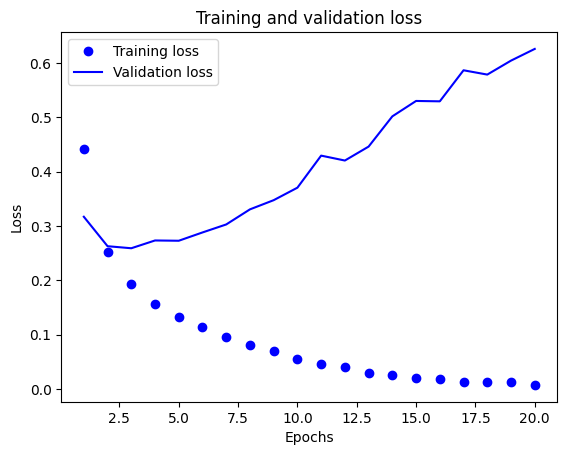

In [ ]:
visualize_performance(ds_history, flag = 'loss')

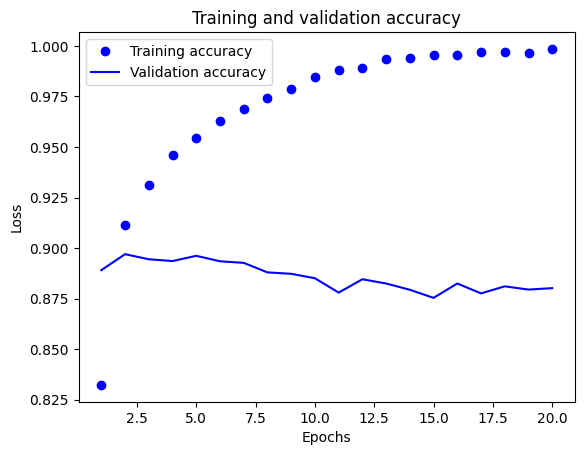

In [ ]:
visualize_performance(ds_history, flag = 'accuracy')

### Train a bidirectional LSTM with self-trained embedding

**Vectorize text to a sequence of indices**

In [ ]:
max_length = 600
max_tokens = 20000
vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
vectorizer.adapt(df['review'])
vectorized_text = vectorizer(df['review'])

In [ ]:
# an example of the vectorized text
vectorized_text[0]

<tf.Tensor: shape=(600,), dtype=int64, numpy=
array([   29,     5,     2,    78,  1942,    45,  1064,    12,   101,
         146,    41,   480,  3326,   394,   462,    27,  3195,    35,
          24,   206,    15,    11,     7,   602,    49,   591,    16,
        2138,    13,     2,    88,   147,    12,  3257,    70,    43,
        3326,    14,    30,  5629,     3, 15403,   135,     5,   583,
          62,   283,     8,   206,    36,     2,   671,   139,  1709,
          70,    11,     7,    22,     4,   119,    17,     2,  8377,
        5825,    40, 11875,    11,   119,  2509,    56,  6073,    16,
        5645,     6,  1471,   382,    40,   583,    30,     7,  3417,
           8,     2,   354,   340,     5,     2,     1,    13,     9,
           7,   470,  3326,    15,    12,     7,     2, 11578,   339,
           6,     2, 16148,  6906,  2546,  1062,     1,     9,  2643,
        1376,    21,     1,   537,    34,  4745,  2521,     5,     2,
        1209,   113,    32,     2,  7204,   

In [ ]:
def decode_text_seq(indices, vectorizer):
  """
  Decode indices back to text
  """
  vocab = vectorizer.get_vocabulary()
  return ' '.join(vocab[i] for i in indices)

In [ ]:
# an example of the decoded text
decode_text_seq(vectorized_text[0], vectorizer)

'one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with mebr br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the [UNK] br it is called oz as that is the nickname given to the oswald maximum security state [UNK] it focuses mainly on [UNK] city an experimental section of the prison where all the cells have glass fronts and face [UNK] so privacy is not high on the agenda em city is home to [UNK] muslims [UNK] latinos christians italians irish and moreso [UNK] death stares dodgy dealings and shady [UNK] are never far awaybr br i would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty pictures painte

**Split data into train/test/validation**

In [ ]:
X_train = vectorized_text[:30000]
X_test = vectorized_text[30000:40000]
X_val = vectorized_text[40000:50000]

y_train = df.label.values[:30000]
y_test = df.label.values[30000:40000]
y_val = df.label.values[40000:50000]

X_train.shape, X_test.shape, X_val.shape

(TensorShape([30000, 600]),
 TensorShape([10000, 600]),
 TensorShape([10000, 600]))

**Build,compile, and train a bidirectional LSTM with a embedding layer**

In [ ]:
# create the embedding layer
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs) # try mask_zero=True

In [ ]:
# build a bidirectional LSTM
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

eb_model = keras.Model(inputs, outputs)
eb_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
eb_model.summary()

# callbacks = [
#     keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
#                                     save_best_only=True)
# ]
# model.fit(X_train, y_train, validation_data=int_val_ds, epochs=10,
#           callbacks=callbacks)
# model = keras.models.load_model("embeddings_bidir_gru.keras")
# print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [ ]:
# train the model
eb_history = eb_model.fit(X_train, y_train, epochs=20, batch_size=512,
                          validation_data=(X_val, y_val))

Epoch 1/20
59/59 [==============================] - 13s 152ms/step - loss: 0.6922 - accuracy: 0.5188 - val_loss: 0.6897 - val_accuracy: 0.5351
Epoch 2/20
59/59 [==============================] - 8s 135ms/step - loss: 0.6491 - accuracy: 0.6285 - val_loss: 0.6153 - val_accuracy: 0.6587
Epoch 3/20
59/59 [==============================] - 8s 132ms/step - loss: 0.5149 - accuracy: 0.7685 - val_loss: 0.4994 - val_accuracy: 0.7798
Epoch 4/20
59/59 [==============================] - 8s 134ms/step - loss: 0.4462 - accuracy: 0.8205 - val_loss: 0.3872 - val_accuracy: 0.8438
Epoch 5/20
59/59 [==============================] - 8s 132ms/step - loss: 0.3751 - accuracy: 0.8561 - val_loss: 0.3404 - val_accuracy: 0.8688
Epoch 6/20
59/59 [==============================] - 8s 134ms/step - loss: 0.3458 - accuracy: 0.8706 - val_loss: 0.3337 - val_accuracy: 0.8757
Epoch 7/20
59/59 [==============================] - 8s 135ms/step - loss: 0.3162 - accuracy: 0.8850 - val_loss: 0.3244 - val_accuracy: 0.8706
Epoch

**Evaluate model performance**

In [ ]:
# evaluate model performance regarding accuracy
test_loss, test_acc = eb_model.evaluate(X_test, y_test)
print(f"test_acc: {np.round(test_acc,3)}")

313/313 [==============================] - 5s 17ms/step - loss: 0.3541 - accuracy: 0.8836
test_acc: 0.884


In [ ]:
# print other evaluation metrics
predict_probs = eb_model.predict(X_test)
y_pred = (predict_probs > 0.5).astype(int)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 5s 15ms/step
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      5022
           1       0.90      0.87      0.88      4978

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



**Visualize model performance during training**

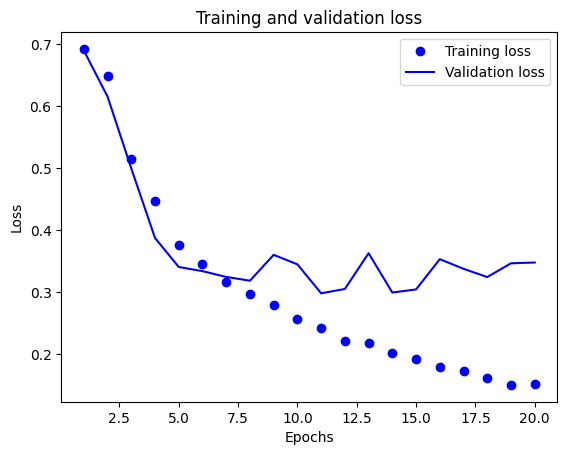

In [ ]:
visualize_performance(eb_history, flag = 'loss')

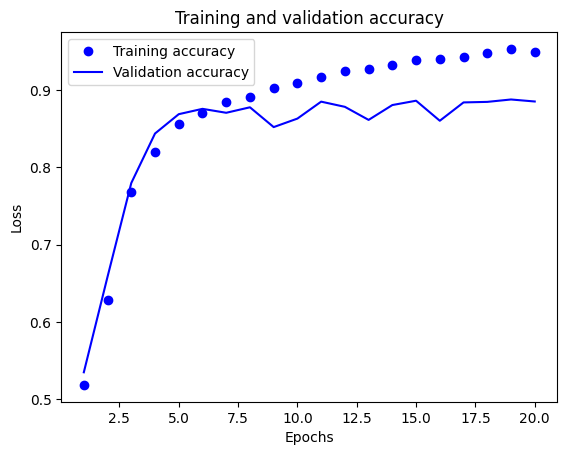

In [ ]:
visualize_performance(eb_history, flag = 'accuracy')

### Train a bidirectional LSTM with pre-trained embedding model

**Get the pre-trained embedding**

In [ ]:
# get the Glove embedding (this takes about 3min)
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

--2024-02-26 18:34:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-02-26 18:34:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-02-26 18:34:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [ ]:
# Parse the GloVe word-embeddings file
# build a map from words to vector representations
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
# an example of the Glove embedding representation for a word
embeddings_index['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [ ]:
# initialize a vectorizer
max_length = 600
max_tokens = 20000
text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorizer.adapt(df['review'])
vectorized_text = text_vectorizer(df['review'])

In [ ]:
X_train = vectorized_text[:30000]
X_test = vectorized_text[30000:40000]
X_val = vectorized_text[40000:50000]

y_train = df.label.values[:30000]
y_test = df.label.values[30000:40000]
y_val = df.label.values[40000:50000]

X_train.shape, X_test.shape, X_val.shape

(TensorShape([30000, 600]),
 TensorShape([10000, 600]),
 TensorShape([10000, 600]))

In [ ]:
# Preparing the GloVe word-embeddings matrix: word_id: vector
embedding_dim = 100

vocabulary = vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(20000, 100)


**Configure an embedding layer**

In [ ]:
# Use a Constant initializer to load the pretrained embeddings in an Embedding layer
# freeze the layer via trainable=False
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

**Build, compile, and train a bidirectional LSTM with pre-trained embeddings**

In [ ]:
# Build a model that utilize a pretrained Embedding layer
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

pre_model = keras.Model(inputs, outputs)
pre_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
pre_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_6 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_8 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2034113 (7.76 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 2000000 (7.63 MB)
_________________

In [ ]:
# train the model
pre_history = pre_model.fit(X_train, y_train, epochs=20, batch_size=512,
                            validation_data=(X_val, y_val))

Epoch 1/20
59/59 [==============================] - 15s 117ms/step - loss: 0.7008 - accuracy: 0.5207 - val_loss: 0.6866 - val_accuracy: 0.5394
Epoch 2/20
59/59 [==============================] - 4s 76ms/step - loss: 0.6792 - accuracy: 0.5648 - val_loss: 0.6835 - val_accuracy: 0.5526
Epoch 3/20
59/59 [==============================] - 4s 75ms/step - loss: 0.6675 - accuracy: 0.5946 - val_loss: 0.6544 - val_accuracy: 0.6225
Epoch 4/20
59/59 [==============================] - 4s 71ms/step - loss: 0.6587 - accuracy: 0.6043 - val_loss: 0.6445 - val_accuracy: 0.6325
Epoch 5/20
59/59 [==============================] - 4s 71ms/step - loss: 0.6520 - accuracy: 0.6166 - val_loss: 0.6860 - val_accuracy: 0.5516
Epoch 6/20
59/59 [==============================] - 4s 72ms/step - loss: 0.6438 - accuracy: 0.6278 - val_loss: 0.6374 - val_accuracy: 0.6319
Epoch 7/20
59/59 [==============================] - 4s 73ms/step - loss: 0.6382 - accuracy: 0.6308 - val_loss: 0.6304 - val_accuracy: 0.6433
Epoch 8/20


**Evaluate model performance**

In [ ]:
# evaluate model performance regarding accuracy
test_loss, test_acc = pre_model.evaluate(X_test, y_test)
print(f"test_acc: {np.round(test_acc,3)}")

313/313 [==============================] - 6s 18ms/step - loss: 0.5544 - accuracy: 0.7113
test_acc: 0.711


In [ ]:
# print other evaluation metrics
predict_probs = pre_model.predict(X_test)
y_pred = (predict_probs > 0.5).astype(int)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 7s 16ms/step
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      5022
           1       0.68      0.79      0.73      4978

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



**Visualize model performance during training**

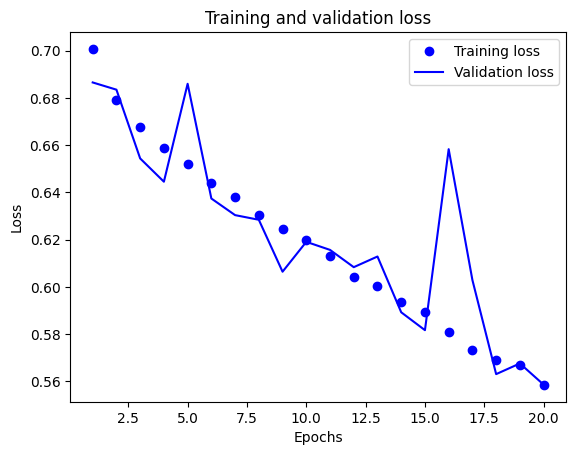

In [ ]:
visualize_performance(pre_history, flag = 'loss')

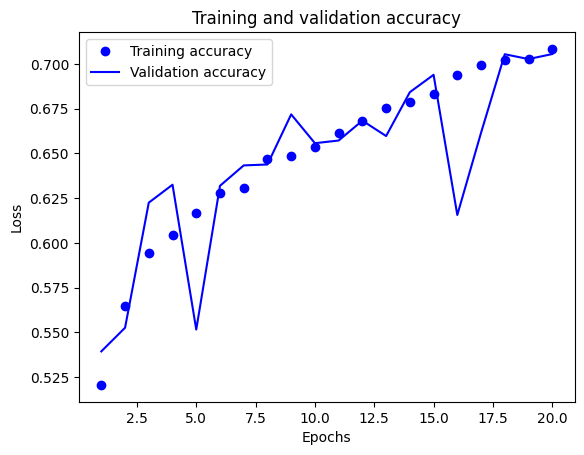

In [ ]:
visualize_performance(pre_history, flag = 'accuracy')

## A multi-class classification example with newswires dataset

**Load the dataset**

In [ ]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2110848/2110848 [==============================] - 0s 0us/step


In [ ]:
len(train_data), len(test_data)

(8982, 2246)

In [ ]:
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [ ]:
# check the label distribution
sorted(Counter(train_labels).items())

[(0, 55),
 (1, 432),
 (2, 74),
 (3, 3159),
 (4, 1949),
 (5, 17),
 (6, 48),
 (7, 16),
 (8, 139),
 (9, 101),
 (10, 124),
 (11, 390),
 (12, 49),
 (13, 172),
 (14, 26),
 (15, 20),
 (16, 444),
 (17, 39),
 (18, 66),
 (19, 549),
 (20, 269),
 (21, 100),
 (22, 15),
 (23, 41),
 (24, 62),
 (25, 92),
 (26, 24),
 (27, 15),
 (28, 48),
 (29, 19),
 (30, 45),
 (31, 39),
 (32, 32),
 (33, 11),
 (34, 50),
 (35, 10),
 (36, 49),
 (37, 19),
 (38, 19),
 (39, 24),
 (40, 36),
 (41, 30),
 (42, 13),
 (43, 21),
 (44, 12),
 (45, 18)]

In [ ]:
# Decoding newswires back to text
def decode_reuters_text(indices):
  word_index = reuters.get_word_index()
  reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
  decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in indices])

  return decoded_newswire


In [ ]:
# an example of the decoded text
decode_reuters_text(train_data[0])

550378/550378 [==============================] - 0s 0us/step


'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

**Text vectorization**

In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

X_train.shape, X_test.shape

((8982, 10000), (2246, 10000))

In [ ]:
# encode the labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [ ]:
# set aside a validation data
X_val = X_train[:1000]
partial_x_train = X_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

**Build, compile, and train a densly connected NN**

In [ ]:
# build the model
multi_model = keras.Sequential([
                    layers.Dense(64, activation="relu"),
                    layers.Dense(64, activation="relu"),
                    layers.Dense(46, activation="softmax")
])

# compile the model
multi_model.compile(optimizer="rmsprop",
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [ ]:
# train the model
multi_history = multi_model.fit(partial_x_train,
                                partial_y_train,
                                epochs=20, batch_size=512,
                                validation_data=(X_val, y_val))

Epoch 1/20
16/16 [==============================] - 3s 115ms/step - loss: 2.7605 - accuracy: 0.5084 - val_loss: 1.9025 - val_accuracy: 0.6030
Epoch 2/20
16/16 [==============================] - 1s 66ms/step - loss: 1.5903 - accuracy: 0.6666 - val_loss: 1.4138 - val_accuracy: 0.6780
Epoch 3/20
16/16 [==============================] - 1s 53ms/step - loss: 1.2235 - accuracy: 0.7270 - val_loss: 1.1997 - val_accuracy: 0.7320
Epoch 4/20
16/16 [==============================] - 1s 78ms/step - loss: 1.0025 - accuracy: 0.7841 - val_loss: 1.0854 - val_accuracy: 0.7590
Epoch 5/20
16/16 [==============================] - 1s 63ms/step - loss: 0.8374 - accuracy: 0.8215 - val_loss: 1.0197 - val_accuracy: 0.7700
Epoch 6/20
16/16 [==============================] - 1s 88ms/step - loss: 0.7018 - accuracy: 0.8483 - val_loss: 0.9477 - val_accuracy: 0.7990
Epoch 7/20
16/16 [==============================] - 2s 123ms/step - loss: 0.5937 - accuracy: 0.8696 - val_loss: 0.9056 - val_accuracy: 0.8120
Epoch 8/20


**Evaluate model performance**

In [ ]:
# evaluate model performance regarding accuracy
test_loss, test_acc = multi_model.evaluate(X_test, y_test)
print(f"test_acc: {np.round(test_acc,3)}")

71/71 [==============================] - 0s 5ms/step - loss: 1.0632 - accuracy: 0.7872
test_acc: 0.787


In [ ]:
# the accuracy of a random baseline
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean().round(3)

0.178

In [ ]:
# print other evaluation metrics
predict_probs = multi_model.predict(X_test)
y_pred = [p.argmax() for p in predict_probs]
print(classification_report(test_labels, y_pred, zero_division=0))

71/71 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.74      0.77      0.75       105
           2       0.58      0.75      0.65        20
           3       0.94      0.91      0.92       813
           4       0.75      0.90      0.82       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       0.33      0.33      0.33         3
           8       0.64      0.71      0.67        38
           9       0.84      0.64      0.73        25
          10       0.93      0.83      0.88        30
          11       0.53      0.83      0.65        83
          12       0.40      0.15      0.22        13
          13       0.61      0.51      0.56        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0.69     

**Visualize model performance during training**

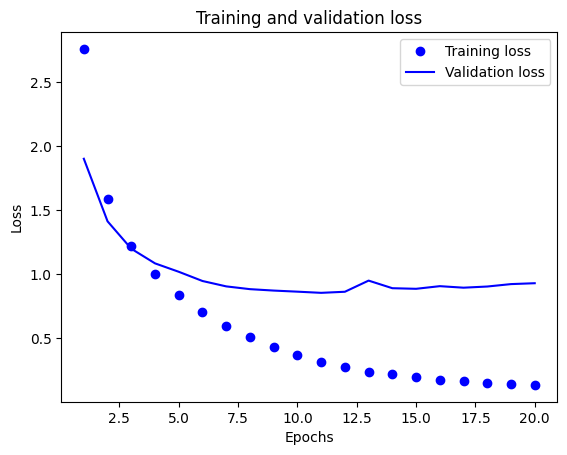

In [ ]:
visualize_performance(multi_history, flag = 'loss')

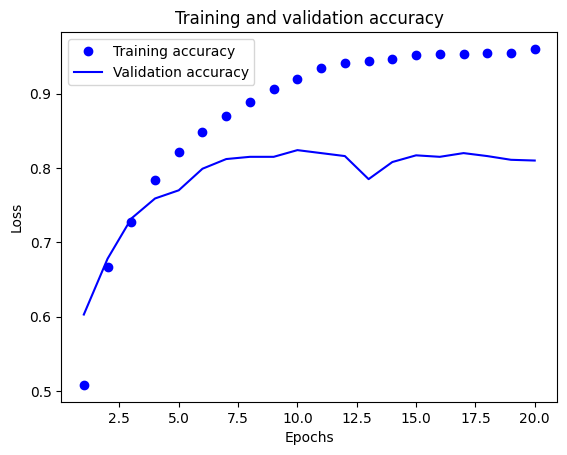

In [ ]:
visualize_performance(multi_history, flag = 'accuracy')